# SINVAD Experiments - Research Question 2 (Boundary Testing)

This notebook provides outlines on experiments performed for RQ2 (Section 5.3 of paper). It contains code that generates results for Figure 6 from our preliminary studies, and Table 3 in the paper. Here we only present the code for MNIST; the principle is similar for FashionMNIST.

## Step 0. Preparation

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm_n
plt.style.use('seaborn')

from sa.model import MnistClassifier
from vae.model import VAE

In [2]:
img_size = 28*28*1
torch.no_grad() # since nothing is trained here

In [3]:
vae = VAE(img_size = 28*28, h_dim = 1600, z_dim = 400)
vae.load_state_dict(torch.load('./vae/models/MNIST_EnD.pth'))
vae.cuda()

classifier = MnistClassifier(img_size = img_size)
classifier.load_state_dict(torch.load('./sa/models/MNIST_conv_classifier.pth'))
classifier.cuda()
print("models loaded")

models loaded


In [4]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
print("Data loader ready")

Data loader ready


## Step 1. Calculate prediction variance in different datasets

In [5]:
def pred_topk_diff(img, classifier, rep_num = 10):
    classifier.eval()
    prob_f = nn.Softmax(dim=1)
    pred = prob_f(classifier(img)).topk(2)[0]
    return abs(pred[0][0]-pred[0][1])

In [6]:
norm_accum = 0.
norm_bound_values = []
for i, (x, x_class) in tqdm_n(enumerate(test_data_loader)):
    samp_img = x[0:1].cuda()
    diff = pred_topk_diff(samp_img, classifier)
    norm_accum += diff.sum().item()
    norm_bound_values.append(diff.item())
print('Dataset test image variation:', norm_accum/10000)


Dataset test image variation: 0.9957110985219478


In [7]:
bound_imgs = np.load('./data/bound_imgs_MNIST.npy')

In [8]:
batch_imgs = bound_imgs.reshape((1, 10000, 28, 28))
batch_imgs = batch_imgs.transpose((1, 0, 2, 3))
tensor_imgs = torch.Tensor(batch_imgs).cuda()

In [9]:
bound_accum = 0.
sinvad_bound_values = []
for img_idx in tqdm_n(range(10000)):
    tensor_img = tensor_imgs[img_idx:img_idx+1]
    diff = pred_topk_diff(tensor_img, classifier)
    bound_accum += diff.sum().item()
    sinvad_bound_values.append(diff.item())
print('SINVAD-generated image variation:', bound_accum/10000)


SINVAD-generated image variation: 0.06384680229574442


In [10]:
_, p_value = ttest_ind(
    sinvad_bound_values,
    norm_bound_values,
    equal_var = False
)
print(p_value)

0.0


In [11]:
def cliff_delta(x, y):
    x_values = np.expand_dims(np.array(x), 0)
    y_values = np.expand_dims(np.array(y), 0).T
    comparison_matrix = (x_values - y_values)
    delta_matrix = np.sign(comparison_matrix)
    cliff_delta = np.sum(delta_matrix)/np.prod(delta_matrix.shape)
    return cliff_delta

cliff_delta(sinvad_bound_values, norm_bound_values)

-0.98077241

## Appendix. Visualization of SINVAD-generated images (Fig. 6)

(-0.5, 251.5, 111.5, -0.5)

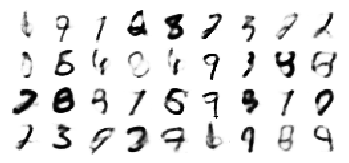

In [12]:
imgs = np.load('./data/bound_imgs_MNIST.npy')
imgs = imgs.reshape((-1, 1, 28, 28))

h_size = 9
v_size = 4
showcase = np.zeros((28*v_size, 28*h_size))
for i in range(v_size):
    for j in range(h_size):
        showcase[28*i:28*(i+1), 28*j:28*(j+1)] = imgs[h_size*i+j]
plt.imshow(showcase)
plt.axis('off')